## Loading model

In [4]:
from keras.models import load_model

saved_model_file = 'mnist_deeplift.h5'
model = load_model(saved_model_file)

## Preprocessing

In [5]:
import tensorflow as tf

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [6]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)
# Making sure that the values are float so that we can get decimal points after division
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# Normalizing the RGB codes by dividing it to the max RGB value.
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print('Number of images in x_train', x_train.shape[0])
print('Number of images in x_test', x_test.shape[0])

from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

x_train shape: (60000, 28, 28, 1)
Number of images in x_train 60000
Number of images in x_test 10000


## Evaluation

In [7]:
model.evaluate(x_test, y_test)

10000/10000 [==============================] - 0s 42us/step


[0.025857398764466008, 0.9919]

## Layers and Parameters of model

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 13, 13, 32)        544       
_________________________________________________________________
activation_1 (Activation)    (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 64)          32832     
_________________________________________________________________
activation_2 (Activation)    (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               204928    
__________

## Prepare the deeplift models

### Model Conversion 

In [9]:
from os.path import dirname, abspath, join
import sys

sys.path.append('/home/muskaanjain/git/deeplift')

import deeplift
from deeplift.layers import NonlinearMxtsMode
from deeplift.conversion import kerasapi_conversion as kc

revealcancel_model = kc.convert_model_from_saved_files(
                            h5_file=saved_model_file,
                            nonlinear_mxts_mode=NonlinearMxtsMode.RevealCancel)

nonlinear_mxts_mode is set to: RevealCancel
28
13
Heads-up: I assume softmax is the output layer, not an intermediate one; if it's an intermediate layer, please let me know and I will prioritise that use-case


### Sanity checks

In [10]:
from deeplift.util import compile_func
import numpy as np
from keras import backend as K

deeplift_model = revealcancel_model
deeplift_prediction_func = compile_func([deeplift_model.get_layers()[0].get_activation_vars()],
                                       deeplift_model.get_layers()[-1].get_activation_vars())
original_model_predictions = model.predict(x_test, batch_size=200)
converted_model_predictions = deeplift.util.run_function_in_batches(
                                input_data_list=[x_test],
                                func=deeplift_prediction_func,
                                batch_size=200,
                                progress_update=None)
print("difference in predictions:",np.max(np.array(converted_model_predictions)-np.array(original_model_predictions)))
assert np.max(np.array(converted_model_predictions)-np.array(original_model_predictions)) < 10**-5
predictions = converted_model_predictions

difference in predictions: 0.0


## Compute Important scores

### Prepare scoring functions

In [93]:
from keras import backend as K
import deeplift
from deeplift.util import get_integrated_gradients_function

revealcancel_func = revealcancel_model.get_target_contribs_func(find_scores_layer_idx=0, target_layer_idx=-2)

### Call scoring functions on dataset

In [94]:
from collections import OrderedDict
method_to_task_to_scores = OrderedDict()

for method_name, score_func in [('revealcancel', revealcancel_func)]:
    print("Computing scores for:",method_name)
    method_to_task_to_scores[method_name] = {}
    for task_idx in range(10):
        print("\tComputing scores for task: "+str(task_idx))
        scores = np.array(score_func(
                    task_idx=task_idx,
                    input_data_list=[x_test],
                    input_references_list=[np.zeros_like(x_test)],
                    batch_size=1000,
                    progress_update=None))
        method_to_task_to_scores[method_name][task_idx] = scores

Computing scores for: revealcancel
	Computing scores for task: 0
	Computing scores for task: 1
	Computing scores for task: 2
	Computing scores for task: 3
	Computing scores for task: 4
	Computing scores for task: 5
	Computing scores for task: 6
	Computing scores for task: 7
	Computing scores for task: 8
	Computing scores for task: 9


In [95]:
scores.shape


(10000, 28, 28, 1)

## Plotting figures

In [96]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from keras import backend as K


#Function to plot scores of an MNIST figure
def viz_scores(scores,ax):
    reshaped_scores = scores.reshape(28,28)
    the_min = np.min(reshaped_scores)
    the_max = np.max(reshaped_scores)
    center = 0.0
    negative_vals = (reshaped_scores < 0.0)*reshaped_scores/(the_min + 10**-7)
    positive_vals = (reshaped_scores > 0.0)*reshaped_scores/float(the_max)
    reshaped_scores = -negative_vals + positive_vals
    ax.imshow(-reshaped_scores, cmap="Greys")
    ax.set_xticks([])
    ax.set_yticks([])


In [97]:
y_pred = model.predict(x_test, batch_size=200)

In [98]:
predictions = np.argmax(y_pred, axis=1)

### Example of right predictions

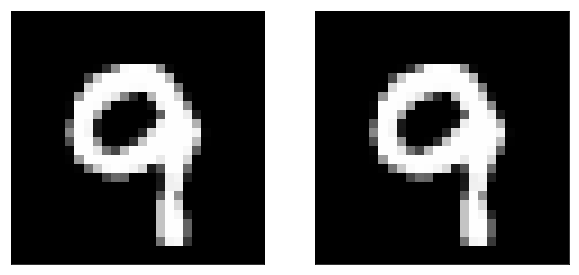

In [100]:
idx = 99
(_, _), (test, _) = tf.keras.datasets.mnist.load_data()
f, axarr = plt.subplots(1, 2, sharey=False, figsize=(10,10))
viz_scores(x_test[idx], axarr[0]) 
viz_scores(test[idx], axarr[1])   

In [101]:
predictions[idx]

9

In [102]:
#Function that masks out the top n pixels where the score for
#task_1 is higher than the score for task_2
def get_masked_image(idx, scores, task_1, task_2, n_to_erase):
    difference = scores[task_1][idx].ravel() - scores[task_2][idx].ravel()
    #highlight the top n
    top_nth_threshold = max(sorted(difference, reverse=True)[n_to_erase],0.0)
    thresholded_points = 1.0*(difference >= top_nth_threshold)
    masked_inp = thresholded_points.reshape(28,28,1)*x_test[idx]
    return masked_inp

### Features responsible for prediction of the following image as 9 and not 1

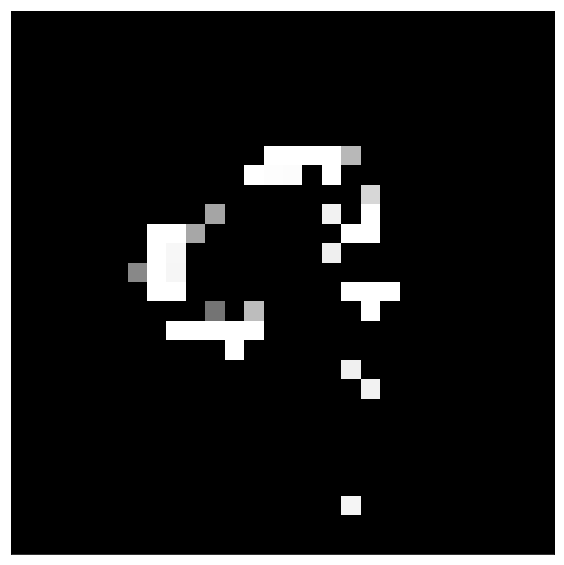

In [103]:
f, axarr = plt.subplots(1, 1, sharey=False, figsize=(10,10))
viz_scores(get_masked_image(idx, method_to_task_to_scores['revealcancel'], 9, 1, 40), axarr)

### Example of wrong predictions

In [104]:
(_, _), (_, test) = tf.keras.datasets.mnist.load_data()
difference = predictions.ravel() - test.ravel()
test_point = -1
for i in range(len(predictions)):
    if(difference[i] != 0):
        test_point = i
        break

prediction value =  9


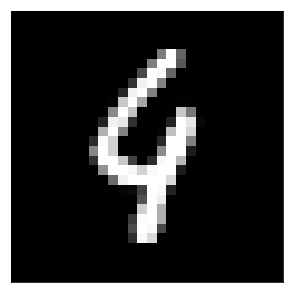

In [105]:
idx = test_point
f, axarr = plt.subplots(1, 1, sharey=False, figsize=(5,5))
viz_scores(x_test[idx], axarr) 
print("prediction value = ", predictions[test_point])

### Top contributing features for prediction as 4 and 9 for an image indexed as test_point

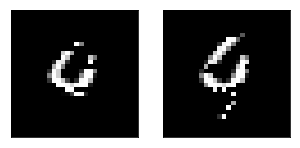

In [106]:
n_to_erase = 200
scores_1 = method_to_task_to_scores['revealcancel'][4][test_point].ravel()
scores_2 = method_to_task_to_scores['revealcancel'][9][test_point].ravel()

top_nth_threshold_1 = max(sorted(scores_1, reverse=True)[n_to_erase],0.0)
top_nth_threshold_2 = max(sorted(scores_2, reverse=True)[n_to_erase],0.0)

thresholded_points_1 = 1.0*(scores_1 >= top_nth_threshold_1)
thresholded_points_2 = 1.0*(scores_2 >= top_nth_threshold_2)

masked_inp_1 = thresholded_points_1.reshape(28,28,1)*x_test[test_point]
masked_inp_2 = thresholded_points_2.reshape(28,28,1)*x_test[test_point]

f, axarr = plt.subplots(1, 2, sharey=False, figsize=(5, 5))
viz_scores(masked_inp_1, axarr[0])
viz_scores(masked_inp_2, axarr[1])

### Learned kernels

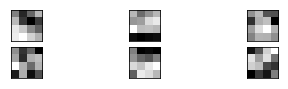

In [107]:
filters, biases = model.layers[0].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 6, 1
for i in range(n_filters):
	# get the filter
	f = filters[:, :, :, i]
	# plot each channel separately
	for j in range(1):
		# specify subplot and turn of axis
		ax = plt.subplot(n_filters, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(f[:, :, j], cmap='gray')
		ix += 1
# show the figure
plt.show()

In [108]:
from keras.models import Model
from numpy import expand_dims

model = Model(inputs=model.inputs, outputs=model.layers[2].output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 32)        544       
_________________________________________________________________
activation_1 (Activation)    (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 64)          32832     
Total params: 33,376
Trainable params: 33,376
Non-trainable params: 0
_________________________________________________________________


### High level extracted features

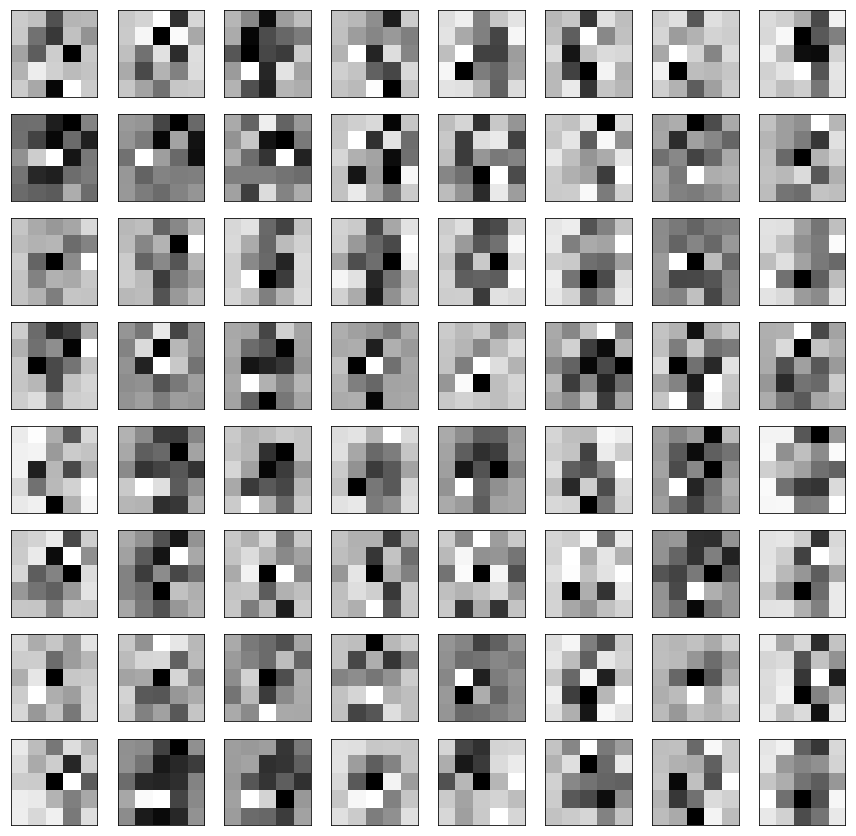

In [109]:
# get feature map for first hidden layer
img = x_test[idx].reshape(1, 28, 28, 1)
feature_maps = model.predict(img)
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
f, axarr = plt.subplots(8, 8, sharey=False, figsize=(15,15))

for i in range(square):
    for j in range(square):
        ax = axarr[i][j]
        # specify subplot and turn of axis
      
        
        # plot filter channel in grayscale
        ax.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ix += 1
# show the figure
plt.show()

### Contribution scores of high level features 

In [110]:
feature_maps.shape

(1, 5, 5, 64)

In [111]:
task_to_scores = OrderedDict()

revealcancel_func = revealcancel_model.get_target_contribs_func(find_scores_layer_idx=3, target_layer_idx=-2)
for task_idx in range(10):
        print("\tComputing scores for task: "+str(task_idx))
        scores = np.array(revealcancel_func(
                    task_idx=task_idx,
                    input_data_list=[x_test],
                    input_references_list=[np.zeros_like(x_test)],
                    batch_size=1000,
                    progress_update=None))
        task_to_scores[task_idx] = scores

	Computing scores for task: 0
	Computing scores for task: 1
	Computing scores for task: 2
	Computing scores for task: 3
	Computing scores for task: 4
	Computing scores for task: 5
	Computing scores for task: 6
	Computing scores for task: 7
	Computing scores for task: 8
	Computing scores for task: 9


In [112]:
def viz_scores(scores,ax):
    reshaped_scores = scores.reshape(5, 5)
    the_min = np.min(reshaped_scores)
    the_max = np.max(reshaped_scores)
    center = 0.0
    negative_vals = (reshaped_scores < 0.0)*reshaped_scores/(the_min + 10**-7)
    positive_vals = (reshaped_scores > 0.0)*reshaped_scores/float(the_max)
    reshaped_scores = -negative_vals + positive_vals
    ax.imshow(-reshaped_scores, cmap="Greys")
    ax.set_xticks([])
    ax.set_yticks([])


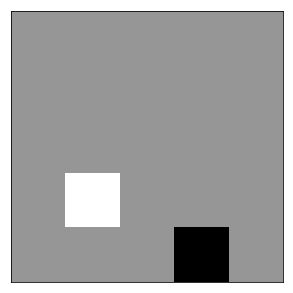

In [113]:
f, axarr = plt.subplots(1, 1, sharey=False, figsize=(5,5))
viz_scores(task_to_scores[9][idx, :, :, 0], axarr)

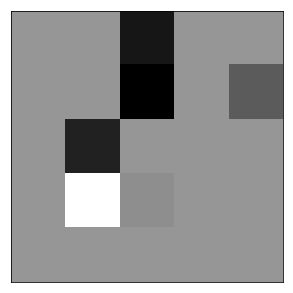

In [114]:
n_to_erase = 5
score = scores[idx, :, :, 0].ravel()
#highlight the top n
top_nth_threshold = max(sorted(score, reverse=True)[n_to_erase],0.0)
thresholded_points = 1.0*(score >= top_nth_threshold)
masked_inp = thresholded_points.reshape(5, 5, 1)*feature_maps[0, :, :, 0].reshape(5, 5, 1)
f, axarr = plt.subplots(1, 1, sharey=False, figsize=(5,5))
viz_scores(masked_inp, axarr)

### Essence of a class

In [123]:
def viz_scores(scores,ax):
    reshaped_scores = scores.reshape(28, 28)
    the_min = np.min(reshaped_scores)
    the_max = np.max(reshaped_scores)
    center = 0.0
    negative_vals = (reshaped_scores < 0.0)*reshaped_scores/(the_min + 10**-7)
    positive_vals = (reshaped_scores > 0.0)*reshaped_scores/float(the_max)
    reshaped_scores = -negative_vals + positive_vals
    ax.imshow(-reshaped_scores, cmap="Greys")
    ax.set_xticks([])
    ax.set_yticks([])

def score_average(task_idx):
    correct_predicted_class = []
    task_idx = task_idx

    (_, _), (_, test) = tf.keras.datasets.mnist.load_data()
    for i in range(len(predictions)):
        if(predictions[i] == test[i] and predictions[i] == task_idx):
            correct_predicted_class.append(i)
    X = x_test[correct_predicted_class]
    revealcancel_func = revealcancel_model.get_target_contribs_func(find_scores_layer_idx=0, target_layer_idx=-2)
    score = np.array(revealcancel_func(
                    task_idx=task_idx,
                    input_data_list=[X],
                    input_references_list=[np.zeros_like(X)],
                    batch_size=1000,
                    progress_update=None))
    score_sum = np.sum(score, axis=0)
    score_avg = score_sum/len(correct_predicted_class)
    return score_avg

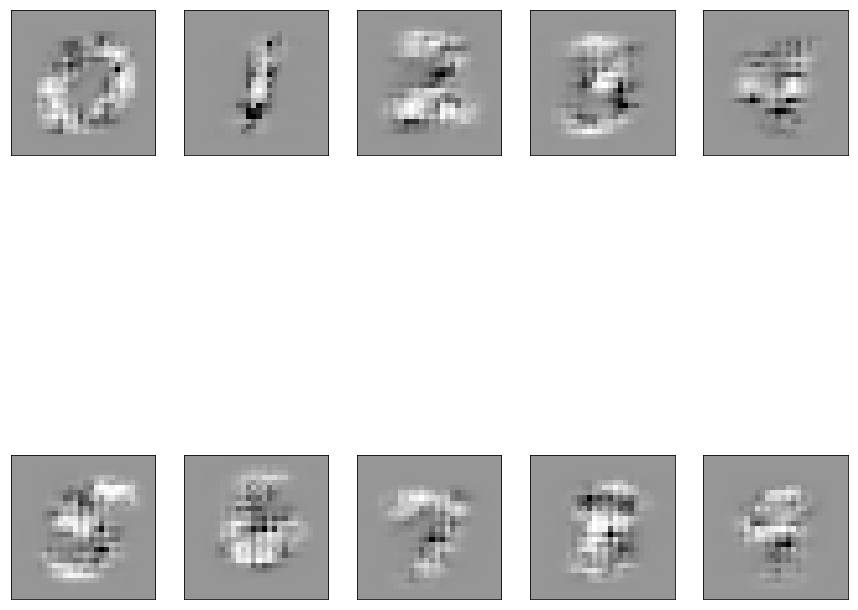

In [124]:
ix = 1
f, axarr = plt.subplots(2, 5, sharey=False, figsize=(15,15))

for i in range(2):
    for j in range(5):
        ax = axarr[i][j]
        viz_scores(score_average(ix-1), ax)
        ix += 1
# show the figure
plt.show()

[[0.09932697 0.1074179  0.08731661 0.0822196  0.10984559 0.09763042
  0.06529192 0.11232474 0.13333103 0.10529526]]


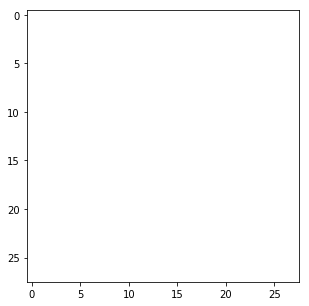

In [18]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt

img = np.zeros([28, 28])
f, axarr = plt.subplots(1, 1, sharey=False, figsize=(5, 5))
axarr.imshow(img, cmap='Greys')

img = img.reshape(1, 28, 28, 1)
output = model.predict(img)
print(output)